In [1]:
import numpy as np
import scipy
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity, Operator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator, Sampler
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import expm, cosm
import warnings
import time

In [43]:
import qiskit
print(qiskit.__version__)

1.3.1


In [44]:
import qiskit_aer
print(qiskit_aer.__version__)

0.15.1


In [18]:
def get_hamiltonian(nqubits):
    J=1/np.sqrt(2)
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()
    
def ansatz_hamiltonian(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for i in range(nqubits):
        circuit.h(i)
    for idepth in range(depth):
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rzz(params[t], i, j)
            t += 1
        circuit.barrier()
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0    
            circuit.rx(params[t], i)
            t += 1
    return circuit    
    
def ansatz_hea(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for idepth in range(depth):
        for i in range(nqubits):
            circuit.ry(params[t], i)
            t += 1
        circuit.barrier()
        for i in range(nqubits-1):
            circuit.cx(i, i+1)
    return circuit    
   
def cost_function1(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hamiltonian(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    circuit.save_statevector() 
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data
    expectation = (u.conj().dot(hamiltonian.to_matrix())).dot(u)
    return expectation.real
    
def cost_function2(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hea(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,['cx'])
    sim_d = AerSimulator(noise_model=noise_model)
    circuit.save_statevector()
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
        circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result = simulator.run(circuit).result()
    u=result.data(0)['statevector'].data
    expectation = (u.conj().dot(hamiltonian.to_matrix())).dot(u)
    return expectation.real


    # print(
    #     f"{intermediate_result.fun}"
    #     )
    #with open('intermediate_values_hva.txt', 'a') as file:
     #   file.write(f'Intermediate values: {intermediate_result.fun}\n')
    


In [3]:
def ansatz_hea(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for idepth in range(depth):
        for i in range(nqubits):
            circuit.ry(params[t], i)
            t += 1
        circuit.barrier()
        for i in range(nqubits-1):
            circuit.cx(i, i+1)
    return circuit

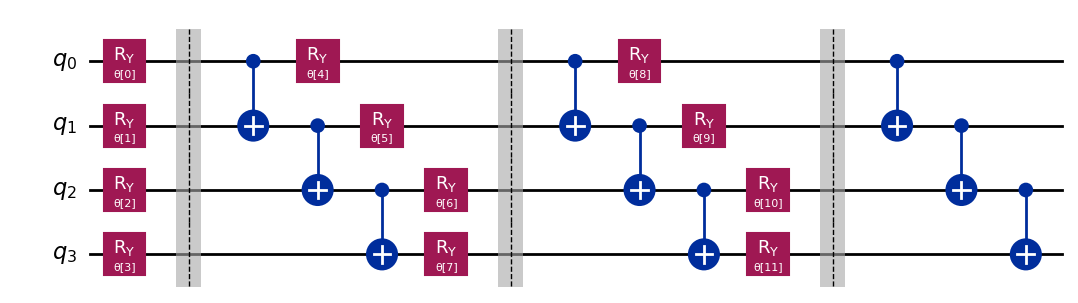

In [5]:
nqubits = 4
depth = 3
np.random.seed(42)  # Example seed
J = 1/np.sqrt(2)
error_rate = 0
parameter = ParameterVector('θ', 20)
circuit= ansatz_hea(nqubits, depth,parameter)
circuit.draw('mpl')

In [17]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate = []
def callback(intermediate_result):
    result_intermediate.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)

In [15]:
estimate_val_hva

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.695518130034755
        x: [-2.859e-01  1.246e+00 ...  8.907e-01  1.403e+00]
      nit: 25
      jac: [ 5.305e-06  2.235e-06 ...  1.341e-06  2.384e-07]
 hess_inv: [[ 1.133e+00 -6.420e-01 ...  9.044e-01  3.895e-01]
            [-6.420e-01  3.580e+00 ... -1.997e+00 -1.594e+00]
            ...
            [ 9.044e-01 -1.997e+00 ...  3.811e+00  1.567e+00]
            [ 3.895e-01 -1.594e+00 ...  1.567e+00  2.139e+00]]
     nfev: 493
     njev: 29

In [13]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="CG", tol=1e-5, options={'disp': False}, callback=callback)
estimate_val_hva

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -3.6955181299045385
       x: [-2.114e-01  1.319e+00 ...  4.851e-01  1.445e+00]
     nit: 50
     jac: [-6.735e-06 -1.311e-06 ... -1.401e-06  3.636e-06]
    nfev: 1394
    njev: 82

In [64]:
print(result_intermediate)

[np.float64(-1.1465461334971725), np.float64(-2.602898278610668), np.float64(-2.848093975370957), np.float64(-3.206002232409881), np.float64(-3.31999428128968), np.float64(-3.438404415746435), np.float64(-3.5373624012173117), np.float64(-3.605473013743551), np.float64(-3.6484026250500903), np.float64(-3.6620230123786675), np.float64(-3.670442766652141), np.float64(-3.6765937053290374), np.float64(-3.6807427907197283), np.float64(-3.686548613996737), np.float64(-3.6930313139650974), np.float64(-3.694791996751512), np.float64(-3.6951775058462046), np.float64(-3.6953272833346285), np.float64(-3.6954448672760325), np.float64(-3.6954921878987657), np.float64(-3.695513648805893), np.float64(-3.6955179670561376), np.float64(-3.6955181144982534), np.float64(-3.695518129747107), np.float64(-3.695518130034755)]


In [65]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-4
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)

In [66]:
result_intermediate1

[np.float64(-1.1465461621634314),
 np.float64(-2.602898276593142),
 np.float64(-2.848094060515354),
 np.float64(-3.2060022979506138),
 np.float64(-3.3199941658900305),
 np.float64(-3.438404472171051),
 np.float64(-3.5373623435434385),
 np.float64(-3.6054728874222026),
 np.float64(-3.632678366048568),
 np.float64(-3.6635702535070798),
 np.float64(-3.6642590682684126),
 np.float64(-3.670386005103789),
 np.float64(-3.678949805863375),
 np.float64(-3.6800208045869933),
 np.float64(-3.6820260574651407),
 np.float64(-3.6856125345085355),
 np.float64(-3.691098413042091),
 np.float64(-3.6940286116271603),
 np.float64(-3.694801413201913),
 np.float64(-3.695227738776236),
 np.float64(-3.695407895335026),
 np.float64(-3.695454921375082),
 np.float64(-3.6955110109933997),
 np.float64(-3.6955175477458178),
 np.float64(-3.6955180240630607),
 np.float64(-3.695518093295617),
 np.float64(-3.6955181287356718),
 np.float64(-3.6955181297871107),
 np.float64(-3.695518130044625)]

In [70]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate2 = []
def callback(intermediate_result):
    result_intermediate2.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)

In [71]:
result_intermediate2

[]

In [73]:
estimate_val_hva

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.3282640485102446
        x: [ 3.745e-01  9.507e-01 ...  1.818e-01  1.834e-01]
      nit: 0
      jac: [-4.064e-01 -1.008e+00 ... -5.767e+07 -3.018e-02]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 403
     njev: 23

In [74]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-2
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate3 = []
def callback(intermediate_result):
    result_intermediate3.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate3

[np.float64(-0.6014272442084743)]

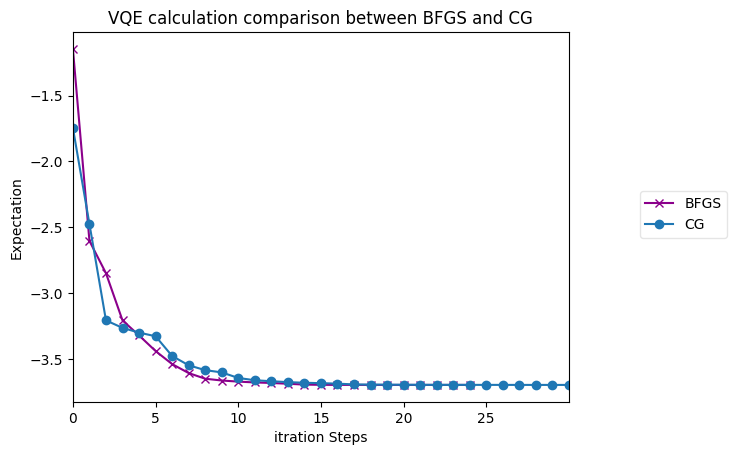

In [18]:
x = np.linspace(0, 200)  # 11个点
y = result_intermediate  # 只有6个点
y1 = result_intermediate1
#y1 = result_intermediate1
#y2 = result_intermediate2
#y3 = result_intermediate3
# 创建figure和axes对象
fig, ax = plt.subplots()
# 使用axes对象绘制数据，不指定x值，默认使用索引
ax.plot(y, label='BFGS', marker="x", c="darkmagenta", ls="-")
ax.plot(y1, label='CG', marker='o', linestyle='-')
#ax.plot(y2, label='1e-3 error_rate', marker="v", c="r", ls="-")
#ax.plot(y3, label='1e-2 error_rate', marker="v", c="r", ls="-")
legend = fig.legend(
            *ax.get_legend_handles_labels(),
            bbox_to_anchor=(1.0, 0.5),
            loc="center left",
            framealpha=0.5,
        )
# 设置x轴刻度为索引值
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 30, 5))
# 添加标题和标签
ax.set_title('VQE calculation comparison between BFGS and CG')
ax.set_xlabel('itration Steps')
ax.set_ylabel('Expectation')
# 显示网格
ax.grid(False)
# 展示图形
plt.show()

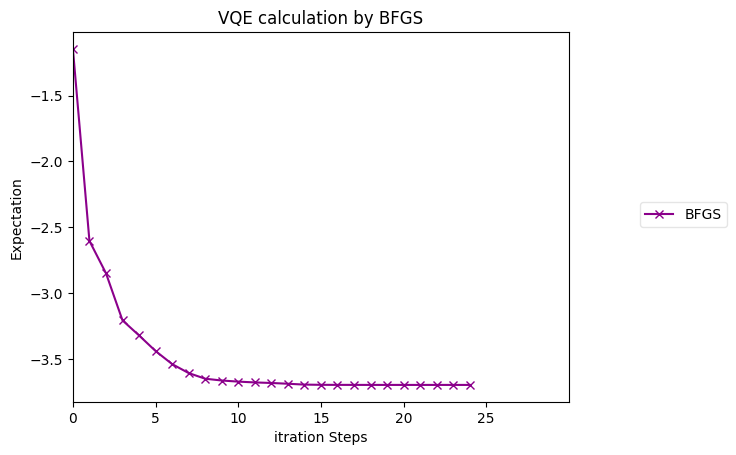

In [16]:
x = np.linspace(0, 200)  # 11个点
y = result_intermediate  # 只有6个点
#y1 = result_intermediate1
fig, ax = plt.subplots()
# 使用axes对象绘制数据，不指定x值，默认使用索引
ax.plot(y, label='BFGS', marker="x", c="darkmagenta", ls="-")
#ax.plot(y1, label='CG', marker='o', linestyle='-')
#ax.plot(y2, label='1e-3 error_rate', marker="v", c="r", ls="-")
#ax.plot(y3, label='1e-2 error_rate', marker="v", c="r", ls="-")
legend = fig.legend(
            *ax.get_legend_handles_labels(),
            bbox_to_anchor=(1.0, 0.5),
            loc="center left",
            framealpha=0.5,
        )
# 设置x轴刻度为索引值
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 30, 5))
# 添加标题和标签
ax.set_title('VQE calculation by BFGS')
ax.set_xlabel('itration Steps')
ax.set_ylabel('Expectation')
# 显示网格
ax.grid(False)
# 展示图形
plt.show()

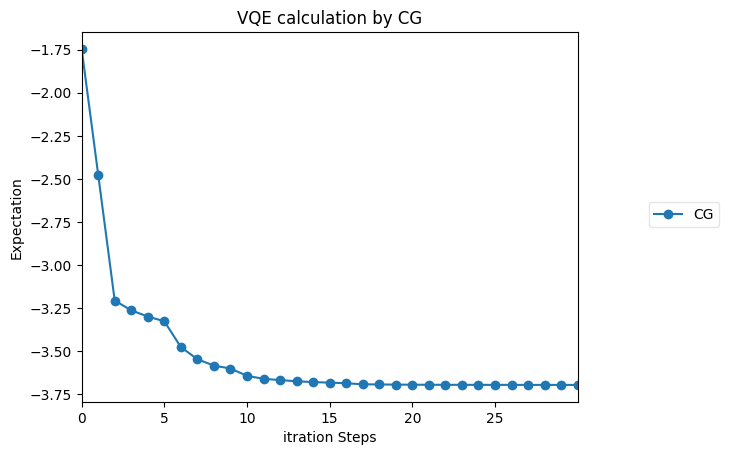

In [17]:
plt.show()
x = np.linspace(0, 200)  # 11个点
#y = result_intermediate  # 只有6个点
y1 = result_intermediate1
fig, ax = plt.subplots()
# 使用axes对象绘制数据，不指定x值，默认使用索引
#ax.plot(y, label='BFGS', marker="x", c="darkmagenta", ls="-")
ax.plot(y1, label='CG', marker='o', linestyle='-')
#ax.plot(y2, label='1e-3 error_rate', marker="v", c="r", ls="-")
#ax.plot(y3, label='1e-2 error_rate', marker="v", c="r", ls="-")
legend = fig.legend(
    *ax.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
# 设置x轴刻度为索引值
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 30, 5))
# 添加标题和标签
ax.set_title('VQE calculation by CG')
ax.set_xlabel('itration Steps')
ax.set_ylabel('Expectation')
# 显示网格
ax.grid(False)
# 展示图形
plt.show()

In [10]:
get_hamiltonian(4)

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j,
 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j])

In [20]:
np.random.seed(42)  # Example seed

nqubits = 4
J = 1/np.sqrt(2)
depth = 3
error_rate = 0
parameter = np.array(np.random.random(4*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate = []
#def callback(intermediate_result):
#    result_intermediate.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function2, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False})#, callback=callback)
estimate_val_hva.fun

np.float64(-3.695518130028156)

In [28]:
def cost_function(params, nqubits, depth, error_rate):
    J = 1/np.sqrt(2)
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hea(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real

def vqe(nqubits, depth, error_rate):
    #vqe_nparams = depth * 2 * nqubits  ## hva
    vqe_nparams = depth * nqubits ## hea
    vqe_params = np.random.random(vqe_nparams)
    result_intermediate = []
    def callback(intermediate_result):
        result_intermediate.append(intermediate_result.fun)
    estimate_val = scipy.optimize.minimize(cost_function, vqe_params, args=(nqubits, depth, error_rate), method="BFGS",
                                        tol=1e-5,
                                        options={'disp': True}, callback=callback)
    print(estimate_val)
    return result_intermediate

print(len(vqe(4,3,0)))

Optimization terminated successfully.
         Current function value: -3.695518
         Iterations: 31
         Function evaluations: 429
         Gradient evaluations: 33
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.695518130042751
        x: [ 9.735e-01  1.571e+00  1.135e+00  1.434e+00  5.310e+00
             7.080e-01  8.275e-01  6.125e-01  1.571e+00  1.664e+00
             1.715e+00  1.856e+00]
      nit: 31
      jac: [ 3.874e-07  1.490e-07 -1.490e-07  1.192e-07  3.576e-07
             1.192e-07  1.043e-06  8.941e-08  3.874e-07  2.384e-07
            -1.162e-06  8.941e-08]
 hess_inv: [[ 1.023e+00  5.003e-01 ...  5.078e-01 -5.120e-01]
            [ 5.003e-01  3.974e+00 ... -1.266e-01  1.663e-01]
            ...
            [ 5.078e-01 -1.266e-01 ...  2.685e+00 -1.859e+00]
            [-5.120e-01  1.663e-01 ... -1.859e+00  2.656e+00]]
     nfev: 429
     njev: 33
31


In [5]:
nqubits = 8
depth = 3
parameter = np.array(np.random.random(2*nqubits*depth))
circuit = ansatz_hamiltonian(nqubits, depth, parameter)
circuit = circuit.decompose(reps=2)
count = []
count.append(circuit.depth()) #depth, total gate, nonlocal gates
count.append(len(circuit))
count.append(circuit.num_nonlocal_gates())
print(count)

[76, 107, 48]


In [68]:
a = 0.0003
print(f"{a:.2e}")

3.00e-04


In [ ]:

start_time = time.time()

In [8]:
## Sampler
# 1. A quantum circuit for preparing the quantum state |000> + i |111>
qc_example = QuantumCircuit(3)
qc_example.h(0)          # generate superpostion
qc_example.p(np.pi/2,0)  # add quantum phase
qc_example.cx(0,1)       # 0th-qubit-Controlled-NOT gate on 1st qubit
qc_example.cx(0,2)       # 0th-qubit-Controlled-NOT gate on 2nd qubit
operator = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])
# 2. Add the classical output in the form of measurement of all qubits
qc_measured = qc_example.measure_all(inplace=False)
# 3. Execute using the Sampler primitive
sampler = StatevectorSampler()
job = sampler.run([qc_measured], shots=1000)
result = job.result()
print(f" > Counts: {result[0].data.meas.get_counts()}")

 > Counts: {'000': 496, '111': 504}


In [9]:
import qiskit
print(qiskit.__version__)

1.3.1


In [10]:
## Estimator
estimator = StatevectorEstimator()
job = estimator.run([(qc_example, operator)], precision=1e-3)
result = job.result()
print(f" > Expectation values: {result[0].data.evs}")

 > Expectation values: 4.000392893466742


In [13]:
## Estimator
estimator = Estimator()
job = estimator.run(qc_example, operator, precision=1e-3)
result = job.result()
result.values
#print(f" > Expectation values: {result[0].data.evs}")

C:\Users\schauue\AppData\Local\Temp\ipykernel_45308\316892537.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


array([4.])

In [14]:
hamiltonian = operator
min(np.linalg.eigvalsh(hamiltonian.to_matrix()))

np.float64(-4.0)

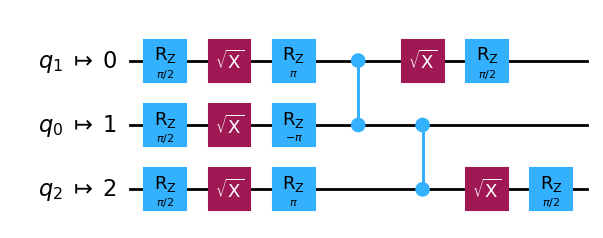

In [117]:
qc_transpiled = transpile(qc_example, basis_gates = ['cz', 'sx', 'rz'], coupling_map =[[0, 1], [1, 2]] , optimization_level=3)
qc_transpiled.draw('mpl')

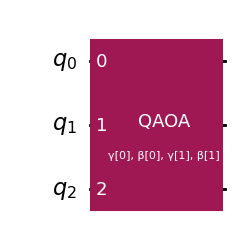

In [119]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

operator = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])
circuit = QAOAAnsatz(operator, reps=2)
circuit.draw('mpl')

## Use AerSimulator from qiskit

In [25]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva1 = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
estimate_val_hva1

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.8255944695241553
        x: [ 3.745e-01  9.507e-01 ...  1.818e-01  1.834e-01]
      nit: 1
      jac: [ 3.373e+07  3.373e+07 ...  3.373e+07  3.373e+07]
 hess_inv: [[ 8.991e-01 -8.590e-02 ... -8.590e-02 -8.590e-02]
            [-8.590e-02  1.000e+00 ... -1.932e-09 -3.203e-09]
            ...
            [-8.590e-02 -1.932e-09 ...  1.000e+00  1.084e-09]
            [-8.590e-02 -3.203e-09 ...  1.084e-09  1.000e+00]]
     nfev: 352
     njev: 20

In [30]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva1 = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="CG", tol=1e-5, options={'disp': False}, callback=callback)
estimate_val_hva1

 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 0.2909692467521529
       x: [ 3.745e-01  9.507e-01 ...  1.818e-01  1.834e-01]
     nit: 2
     jac: [-1.111e+07  6.961e+07 ...  6.961e+07  6.961e+07]
    nfev: 476
    njev: 27

In [35]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva1 = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="Nelder-Mead", tol=1e-5, options={'disp': False}, callback=callback)
estimate_val_hva1

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -1.2304078702441865
             x: [ 3.787e-01  9.697e-01 ...  1.807e-01  1.851e-01]
           nit: 661
          nfev: 3200
 final_simplex: (array([[ 3.787e-01,  9.697e-01, ...,  1.807e-01,
                         1.851e-01],
                       [ 3.787e-01,  9.697e-01, ...,  1.807e-01,
                         1.851e-01],
                       ...,
                       [ 3.787e-01,  9.697e-01, ...,  1.807e-01,
                         1.851e-01],
                       [ 3.787e-01,  9.697e-01, ...,  1.807e-01,
                         1.851e-01]], shape=(17, 16)), array([-1.230e+00, -3.322e-01, ...,  1.239e+00,  1.239e+00],
                      shape=(17,)))

In [20]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-2
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate2 = []
def callback(intermediate_result):
    result_intermediate2.append(intermediate_result.fun)
estimate_val_hva2 = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
estimate_val_hva2

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.4791756183231318
        x: [ 3.745e-01  9.507e-01 ...  1.818e-01  1.834e-01]
      nit: 4
      jac: [-2.521e+07 -4.699e+07 ...  8.324e+07  1.214e+08]
 hess_inv: [[ 1.108e+01 -1.115e+00 ... -4.679e+00 -1.118e+00]
            [-1.115e+00  7.996e-01 ...  6.845e-01  3.297e-01]
            ...
            [-4.679e+00  6.845e-01 ...  3.001e+00  3.912e-01]
            [-1.118e+00  3.297e-01 ...  3.912e-01  9.042e-01]]
     nfev: 523
     njev: 30

### Use estimator from qiskit_aer

In [46]:
def cost_function(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hamiltonian(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real

In [47]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
expectation = cost_function(parameter, nqubits, depth, error_rate)
expectation

array(1.32826405)

In [48]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
expectation = cost_function(parameter, nqubits, depth, error_rate)
expectation

array(1.21942165)

In [49]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate = []
def callback(intermediate_result):
    result_intermediate.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate

[-1.146546132116061,
 -2.6028982372512375,
 -2.8480938565785943,
 -3.2060020690785107,
 -3.3199942708126375,
 -3.4384043636342216,
 -3.537362372341709,
 -3.6054730441231895,
 -3.6484027209174577,
 -3.662023081540118,
 -3.670442736465896,
 -3.676593660765858,
 -3.6807427454988653,
 -3.686548537845189,
 -3.69303122725566,
 -3.6947919802622278,
 -3.695177500516187,
 -3.6953272807143134,
 -3.6954448697713076,
 -3.69549218687719,
 -3.6955136487462426,
 -3.695517966962232,
 -3.695518114522142,
 -3.695518129754621,
 -3.6955181300347575]

In [51]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-3
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate1 = []
def callback(intermediate_result):
    result_intermediate1.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
estimate_val_hva

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.359729826752132
        x: [-7.238e-01  7.296e-01 ... -5.392e-01 -1.362e+00]
      nit: 167
      jac: [ 1.013e-06  2.295e-06 ... -3.636e-06 -3.189e-06]
 hess_inv: [[ 4.279e+00 -4.772e+00 ... -6.773e+00  5.910e+00]
            [-4.772e+00  9.178e+00 ...  1.302e+01 -8.965e+00]
            ...
            [-6.773e+00  1.302e+01 ...  3.003e+01 -1.407e+01]
            [ 5.910e+00 -8.965e+00 ... -1.407e+01  1.185e+01]]
     nfev: 3060
     njev: 180

In [43]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-4
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate2 = []
def callback(intermediate_result):
    result_intermediate2.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate2

[-1.1327336346553483,
 -2.573693251145439,
 -2.8268634973436604,
 -3.1862136373965844,
 -3.2858784353000847,
 -3.4041102239161303,
 -3.492750366533888,
 -3.5542639875867055,
 -3.5931666227636025,
 -3.6108328799941214,
 -3.6278525226539227,
 -3.634479225017325,
 -3.63877002341861,
 -3.6454104507345546,
 -3.65041175355045,
 -3.6530895817734876,
 -3.6538353642526946,
 -3.6540714007737414,
 -3.654196374589492,
 -3.654336282504428,
 -3.6543745248461215,
 -3.6543936359179003,
 -3.654398721412571,
 -3.654407107842274,
 -3.6544221910420602,
 -3.654450068229094,
 -3.654499772069532,
 -3.6545541809469215,
 -3.6546093246864477,
 -3.6546994170443257,
 -3.6547984622870437,
 -3.654814493600868,
 -3.6548427656683122,
 -3.654891689114158,
 -3.6549684788058565,
 -3.6550574205325432,
 -3.6550798614412185,
 -3.655118899653179,
 -3.6551794895569567,
 -3.655266340546341,
 -3.6553063796612233,
 -3.655364747612473,
 -3.655441063176196,
 -3.655552687011101,
 -3.6556170705094675,
 -3.6557173618011936,
 -3.6558

In [52]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-2
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate3 = []
def callback(intermediate_result):
    result_intermediate3.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate3

[-0.29384615084282417,
 -0.7570092690545605,
 -0.9536697021568348,
 -1.0862885593052243,
 -1.1023758911424142,
 -1.110610754713142,
 -1.1264770808910556,
 -1.1540714006378234,
 -1.1708574199707147,
 -1.185536170640128,
 -1.2105597503955434,
 -1.239483358508678,
 -1.2620526812137451,
 -1.2992903963371212,
 -1.3384534479394279,
 -1.3635003834776391,
 -1.3831766433506165,
 -1.4030590134874836,
 -1.4145550155301723,
 -1.4204545082020026,
 -1.4223153426234205,
 -1.4231159410854248,
 -1.4233990384482456,
 -1.4236439192149175,
 -1.4238062338045077,
 -1.424002541972481,
 -1.4243336518700498,
 -1.4249177564914492,
 -1.4258760539713922,
 -1.4263437728720176,
 -1.4269421042114399,
 -1.4274245874655145,
 -1.4279272025156753,
 -1.4282641911489047,
 -1.4284956493542071,
 -1.4286163274686339,
 -1.428821760510303,
 -1.429162656989834,
 -1.4297112234171863,
 -1.4305619388221693,
 -1.4317403396699246,
 -1.4328671442736973,
 -1.4338837770413755,
 -1.4345374174729906,
 -1.4351232137112722,
 -1.43539593722

In [53]:
estimate_val_hva

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.436399352261719
        x: [ 3.190e-01  2.780e+00 ...  6.254e-01  1.144e+00]
      nit: 76
      jac: [-8.643e-07 -4.470e-07 ... -5.662e-07 -1.252e-06]
 hess_inv: [[ 4.115e+00 -1.597e+00 ...  1.320e+00  3.050e+00]
            [-1.597e+00  3.744e+00 ...  2.215e+00 -1.958e+00]
            ...
            [ 1.320e+00  2.215e+00 ...  1.849e+01 -6.583e+00]
            [ 3.050e+00 -1.958e+00 ... -6.583e+00  1.663e+01]]
     nfev: 1343
     njev: 79

In [44]:
len(result_intermediate2)

217

In [46]:
hamiltonian = get_hamiltonian(4)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emin

np.float64(-3.6955181300451487)

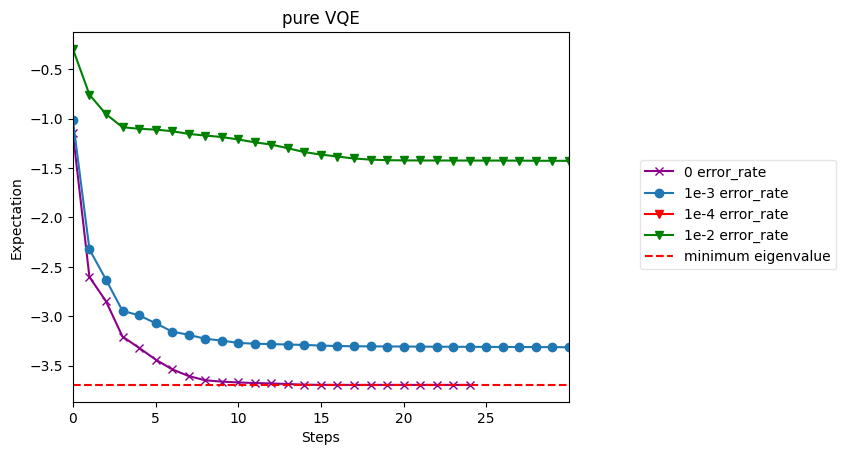

In [79]:
x = np.linspace(0, 250)  # 11个点
y = result_intermediate  # 只有6个点
y1 = result_intermediate1
y2 = result_intermediate2
y3 = result_intermediate3
horizontal_line_value = emin
# 创建figure和axes对象
fig, ax = plt.subplots()
# 使用axes对象绘制数据，不指定x值，默认使用索引
ax.plot(y, label='0 error_rate', marker="x", c="darkmagenta", ls="-")
ax.plot(y1, label='1e-3 error_rate', marker='o', linestyle='-')
ax.plot(y2, label='1e-4 error_rate', marker="v", c="r", ls="-")
ax.plot(y3, label='1e-2 error_rate', marker="v", c="g", ls="-")
ax.axhline(y=horizontal_line_value, color='r', linestyle='--', label='minimum eigenvalue')
legend = fig.legend(
            *ax.get_legend_handles_labels(),
            bbox_to_anchor=(1.0, 0.5),
            loc="center left",
            framealpha=0.5,
        )
# 设置x轴刻度为索引值
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 30, 5))
# 添加标题和标签
ax.set_title('pure VQE')
ax.set_xlabel('Steps')
ax.set_ylabel('Expectation')
# 显示网格
ax.grid(False)
# 展示图形
plt.show()

In [51]:
abs(emin-result_intermediate1[-1])/abs(emin)*100

np.float64(9.086366010844452)

## test

In [52]:
def cost_function1(params, nqubits, depth, error_rate):
    hamiltonian =  get_hamiltonian(nqubits)
    circuit =  ansatz_hamiltonian(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-4
parameter = np.array(np.random.random(2*nqubits*depth))
#ansatz_hamiltonian(nqubits, depth, parameter).draw('mpl')
result_intermediate2temp = []
def callback(intermediate_result):
    result_intermediate2temp.append(intermediate_result.fun)
estimate_val_hva = minimize(cost_function1, parameter, args=(nqubits, depth, error_rate), method="BFGS", tol=1e-5, options={'disp': False}, callback=callback)
result_intermediate2temp

[-1.1327336346553483,
 -2.573693251145439,
 -2.8268634973436604,
 -3.1862136373965844,
 -3.2858784353000847,
 -3.4041102239161303,
 -3.492750366533888,
 -3.5542639875867055,
 -3.5931666227636025,
 -3.6108328799941214,
 -3.6278525226539227,
 -3.634479225017325,
 -3.63877002341861,
 -3.6454104507345546,
 -3.65041175355045,
 -3.6530895817734876,
 -3.6538353642526946,
 -3.6540714007737414,
 -3.654196374589492,
 -3.654336282504428,
 -3.6543745248461215,
 -3.6543936359179003,
 -3.654398721412571,
 -3.654407107842274,
 -3.6544221910420602,
 -3.654450068229094,
 -3.654499772069532,
 -3.6545541809469215,
 -3.6546093246864477,
 -3.6546994170443257,
 -3.6547984622870437,
 -3.654814493600868,
 -3.6548427656683122,
 -3.654891689114158,
 -3.6549684788058565,
 -3.6550574205325432,
 -3.6550798614412185,
 -3.655118899653179,
 -3.6551794895569567,
 -3.655266340546341,
 -3.6553063796612233,
 -3.655364747612473,
 -3.655441063176196,
 -3.655552687011101,
 -3.6556170705094675,
 -3.6557173618011936,
 -3.6558

## qiskit_aer with EstimatorV2

In [61]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 1e-4
params = np.array(np.random.random(2*nqubits*depth))
hamiltonian =  get_hamiltonian(nqubits)
circuit =  ansatz_hea(nqubits, depth, params)
circuit = circuit.decompose()
noise_model = NoiseModel()
error = depolarizing_error(error_rate, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
error1 = depolarizing_error(error_rate*10, 2)
noise_model.add_all_qubit_quantum_error(error1,['cx'])
sim_d = AerSimulator(noise_model=noise_model)
circuit.save_statevector()
circuit.measure_all()
sampler = SamplerV2(options=dict(backend_options=dict(noise_model=noise_model)))
result = sampler.run([circuit]).result()
result[0].data.meas.get_counts()

{'0000': 321,
 '1000': 292,
 '1010': 187,
 '0101': 50,
 '0100': 91,
 '1110': 24,
 '0110': 17,
 '0111': 12,
 '1111': 18,
 '0001': 8,
 '0010': 1,
 '1001': 2,
 '1011': 1}

In [92]:
np.random.seed(42)  # Example seed
nqubits = 4
J = 1/np.sqrt(2)
depth = 2
error_rate = 0
params = np.array(np.random.random(2*nqubits*depth))
hamiltonian =  get_hamiltonian(nqubits)
circuit =  ansatz_hea(nqubits, depth, params)
circuit = circuit.decompose()
noise_model = NoiseModel()
error = depolarizing_error(error_rate, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
error1 = depolarizing_error(error_rate*10, 2)
noise_model.add_all_qubit_quantum_error(error1,['cx'])
sim_d = AerSimulator(noise_model=noise_model)
circuit.save_statevector()
circuit.measure_all()
sampler = SamplerV2(options=dict(backend_options=dict(noise_model=noise_model)))
result = sampler.run([circuit]).result()
result[0].data.meas.get_counts()

{'1000': 250,
 '0000': 386,
 '0101': 35,
 '1010': 194,
 '0100': 98,
 '1110': 24,
 '0110': 14,
 '1001': 1,
 '1111': 8,
 '0001': 4,
 '0111': 4,
 '0010': 4,
 '1100': 1,
 '1011': 1}

In [ ]:
a